In [33]:

import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3 import SAC
from DSAC import DSAC

def evaluate_model(model,env):
    done = False
    rewards = []
    portfolio_worths = []
    obs = env.reset()
    portfolio_worths.append(1.0)
    max_worth = 1.0
    weights = []
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done,info = env.step(action)
        current_worth = info[0]['portfolio_worth']
        portfolio_worths.append(current_worth)
        max_worth = max(max_worth,current_worth)
        weights.append(info[0]['weights'])
        rewards.append(reward)
    return np.array(rewards),np.array(portfolio_worths),np.array(weights)

def calculate_portfolio_metrics(eval_benchmark, portfolio_worths):
    
    quarter = 63 # 63 trading days in a quarter
    
    periodic_portfolio_worths = portfolio_worths[::quarter]
    
    periodic_portfolio_returns = np.log(periodic_portfolio_worths[1:]/periodic_portfolio_worths[:-1])
    sharpe_ratio = np.mean(periodic_portfolio_returns)/np.std(periodic_portfolio_returns)
    
    periodic_benchmark_worths = eval_benchmark[::quarter]
    periodic_benchmark_returns = np.log(periodic_benchmark_worths[1:]/periodic_benchmark_worths[:-1])
    
    excess_returns = periodic_portfolio_returns - periodic_benchmark_returns
    information_ratio = np.mean(excess_returns)/np.std(excess_returns)
    
    drawdowns = (np.maximum.accumulate(periodic_portfolio_worths) - periodic_portfolio_worths)/np.maximum.accumulate(periodic_portfolio_worths)
    max_drawdown = np.max(drawdowns)
    
    print(f'Sharpe Ratio: {sharpe_ratio},  Information Ratio: {information_ratio}, Final Portfolio Worth: {portfolio_worths[-1]}, Max Drawdown: {max_drawdown}')

def evaluate_portfolio(eval_env, eval_benchmark, model):
    rewards,portfolio_worths,weights = evaluate_model(model,eval_env)
    calculate_portfolio_metrics(eval_benchmark, portfolio_worths)
    return portfolio_worths,weights


In [34]:
from std_methods import std_methods

tickers = ['AAPL','JPM','F','PG', 'BA','IBM','XOM']

equal_weights,min_risk,risk_parity,spy,djia,russell = std_methods(tickers,'2015-01-01','2020-18-31','2021-01-01','2024-12-31')

from environments.util import fetch_observations
from environments.benchmark import create_env_benchmark

investment_period = 1 # each 1 investment days 
reward_period = 15 # each 15 investment periods
prices,eval_benchmark,observations,eval_dates = fetch_observations(tickers,investment_period,'2021-01-01','2024-12-31')

eval_env = create_env_benchmark(prices,eval_benchmark,observations,20,0)

print('Equal Weights')
calculate_portfolio_metrics(eval_benchmark, equal_weights)
print('Min Risk')
calculate_portfolio_metrics(eval_benchmark, min_risk)
print('Risk Parity')
calculate_portfolio_metrics(eval_benchmark, risk_parity)
print('SP500')
calculate_portfolio_metrics(eval_benchmark, spy)
print('DJIA')
calculate_portfolio_metrics(eval_benchmark, djia)
print('Russell')
calculate_portfolio_metrics(eval_benchmark, russell)



[2.00194566e-02 3.82803518e-02 8.92097432e-01 4.96027596e-02
 4.81274464e-14 9.30312935e-13 0.00000000e+00]
[1.04750303e-02 1.30762920e-02 9.00893980e-01 1.81269452e-02
 7.01410221e-04 2.80720866e-02 2.86542556e-02]
Equal Weights
Sharpe Ratio: 0.42942711795056454,  Information Ratio: 0.2957192367177769, Final Portfolio Worth: 1.658745598828538, Max Drawdown: 0.1911770928919458
Min Risk
Sharpe Ratio: 0.07233928108839598,  Information Ratio: -0.03676890834417772, Final Portfolio Worth: 1.3161702986084967, Max Drawdown: 0.47960936902118073
Risk Parity
Sharpe Ratio: 0.0873537644358698,  Information Ratio: -0.021340157611081326, Final Portfolio Worth: 1.3597831532743663, Max Drawdown: 0.4643444573752519
SP500
Sharpe Ratio: 0.3904307082040377,  Information Ratio: 0.15762861943719697, Final Portfolio Worth: 1.6220342200168119, Max Drawdown: 0.2087877582633815
DJIA
Sharpe Ratio: 0.35630702751729637,  Information Ratio: 0.04238010928610094, Final Portfolio Worth: 1.4554376497114505, Max Drawdow

In [35]:
def evaluate_SAC(model_path):
    model = SAC.load(f'./models/{model_path}.zip')
    return evaluate_portfolio(eval_env, eval_benchmark, model)

def evaluate_DSAC(model_path):
    bare_model = DSAC(policy='MlpPolicy', env=eval_env, verbose=1)
    bare_model.set_parameters(f'./models/{model_path}.zip')
    return evaluate_portfolio(eval_env, eval_benchmark, bare_model)

DSAC benchmark 1
Using cpu device


d:\.war\satan\.venv\Lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.61GB > 0.81GB
  warnings.warn(


Sharpe Ratio: 0.36598414569833754,  Information Ratio: 0.20539347548493334, Final Portfolio Worth: 1.7548465661675727, Max Drawdown: 0.248388693845403
DSAC max gain 1
Using cpu device
Sharpe Ratio: 0.4392164911472102,  Information Ratio: 0.2464336664575102, Final Portfolio Worth: 1.7791516154436093, Max Drawdown: 0.15964275761864122


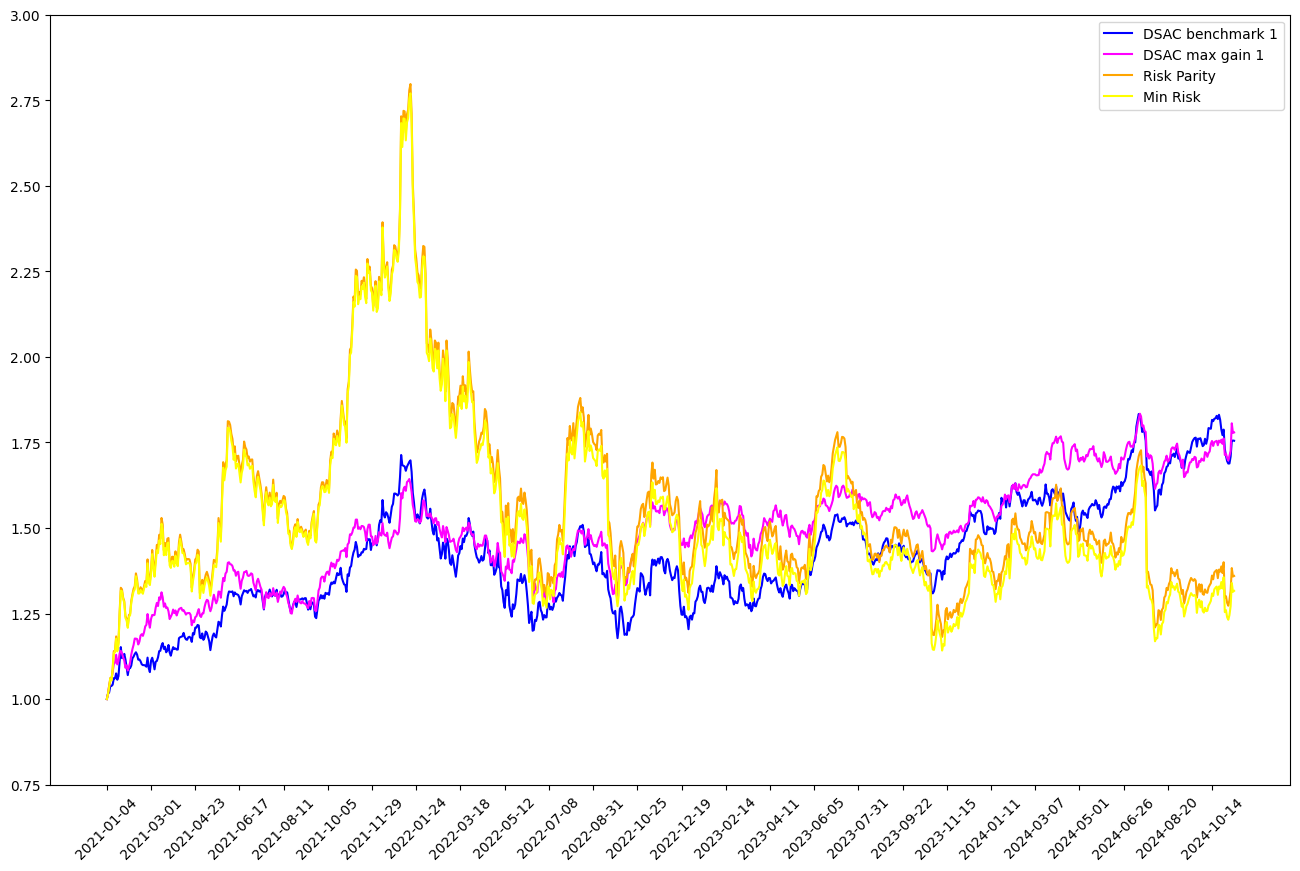

In [36]:
models = {
    'DSAC benchmark 1': 'DSAC_env_5',
    'DSAC max gain 1':  'DSAC_env_10',
}

plt.figure(figsize=(16,10))
i = 0

colors = ['blue','magenta']

for model_name,model_path in models.items():
    print(model_name)
    if 'DSAC' in model_path:
        portfolio_worths,weights = evaluate_DSAC(model_path)
    else:
        portfolio_worths,weights = evaluate_SAC(model_path)
    plt.plot(eval_dates,portfolio_worths, linestyle='-',label=f'{model_name}', color = colors[i])
    
    weights = np.vstack((weights,np.tile(weights[-1],(len(eval_dates)-weights.shape[0],1))))
    i += 1
        

plt.plot(eval_dates,risk_parity, linestyle='-',label='Risk Parity', color = 'orange')
plt.plot(eval_dates,min_risk, linestyle='-',label='Min Risk', color = 'yellow')

plt.xticks(eval_dates[::(len(eval_dates)//25)],rotation=45)
plt.ylim(0.75,3)
plt.legend()